# NB2: Choosing and Training a Model

## Constructing a basic linear model

So far we have peeked at the data and applied two scaling techniques. Let's construct a very basic model to predict precursor at t+n where t is the previous timestep and n represent the lead time. Lead time being t_delta between observation and prediction.

For our model we are give a matrix of predictors **X** and a vector of **y**. We are trying to solve for model *w* which minimizes the following:

$$\text{min}||Xw-y||^2 $$

There will me more on this later. Let's just abstract away model building for now so we can see the importance of feature scaling and normalization.

The general steps here will be.

*Step 1*: Build X and y

*Step 2*: Separate data into a training set, valuation set, and test set. (There is a bit of technique in this, but we will make this simple for now.)

*Step 3*: Use the training set to develop a model that will generalize to the valuation set. 

*Step 4*: Apply changes as necessary to avoid underfitting and overfitting. (More on this later.)

*Step 5*: Apply your model to the test set.

### Helper

In [83]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random


In [3]:
def prepare_data(data, input_columns, output_columns):
    """ Splits data to input/output with corresponding lag """
    
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    x_data = data[input_columns].iloc[:-1, :]
    y_data = data[output_columns].iloc[1:, :]
    
    return x_data, y_data

In [131]:
dataFrame = pd.read_parquet("/glade/work/ochaarawi/ML2019_toluene_ML2019_Exp_0_1999_post_proc.parquet")

Prepare data

### Training, validation, and testing sets
This training dataset/library consists of 2000 GECKO experiments, including results for 5 day runs (1440 timesteps at 300 second intervals). The data has already been split into training/validation/test sets by random expiriments of size 1400/200/200 (and 200 for a hidden test set). Thus, the training set consists of 2,016,000 samples of data and test/validation sets with 288,000 samples.

In [132]:
training_set = dataFrame.iloc[0:2073600]
validation_set = dataFrame.iloc[2073600:2361600]
test_set = dataFrame.iloc[2361600:2649600]


In [133]:
input_vars = dataFrame.columns[[1,2,3,4,5,6,36,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29,30,31,32,33,34]]
output_vars = dataFrame.columns[[1]]
train_in, train_out = prepare_data(training_set, input_vars, output_vars)
val_in, val_out = prepare_data(validation_set, input_vars, output_vars)
test_in, test_out = prepare_data(test_set, input_vars, output_vars)

<ipython-input-3-e96e2b05fa74>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting


In [134]:
train_in_scaled = StandardScaler().fit_transform(train_in)
val_in_scaled = StandardScaler().fit_transform(val_in)
test_in_scaled = StandardScaler().fit_transform(test_in)

In [135]:
train_out = train_out.to_numpy()
val_out = val_out.to_numpy()
test_out = test_out.to_numpy()

In [136]:
choices = range(0,287999)

In [143]:
arr = np.random.choice(choices, size = 100 )

In [138]:
arr.max()

272976

In [139]:
len(predictions)

287999

In [140]:
len(val_out)

287999

RMSE: 0.00


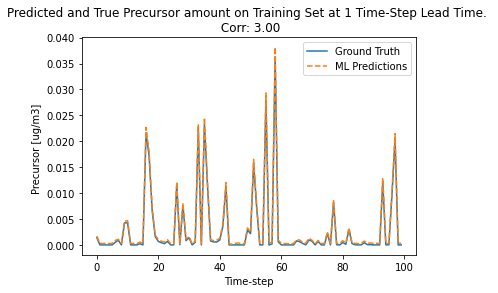

In [144]:
#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(train_in_scaled,train_out)

predictions = regr.predict(test_in_scaled)
# corr, _ = scipy.stats.pearsonr(predictions, val_out)
rmse = mean_squared_error(test_out, predictions)
print("RMSE: {:.2f}".format(rmse))

val = [test_out[x] for x in arr]
pred = [predictions[x] for x in arr]
plot_GECKO_time_series(val, pred, 
    'Predicted and True Precursor amount on Training Set at 1 Time-Step Lead Time. \n Corr: {:.2f}'.format(3))

In [129]:
train_out.iloc[1438:1442]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [94]:
X = dataFrame.drop(columns = ["Time [s]"])

**/glade/work/schreck/repos/GECKO_OPT/gecko-ml/applications/model_comparison.ipynb**

### Input:

Precursor, Temperature, OH, O3, NO, SZA, pre-existing aerosols, Gas binned, Aerosol binned

### Output:

precursor at T+1

#### Mapping predictands to predictor

Because we want to predict amount of precursor at time equals t + 1

In [95]:
drop_indices = [x for x in range(1439,2880000,1440)]

In [96]:
X = X.drop(index=drop_indices)
X = X.reset_index(drop=True)

In [97]:
y = X.loc[1:,'Precursor [ug/m3]']
y = y.reset_index(drop=True)
X['Precursor [ug/m3] at t+1'] = y

In [98]:
X.iloc[1430:1441]

,Precursor [ug/m3],Temperature [K],OH [molec/cm3],O3 [molec/cm3],NOx [molec/cm3],SZA [degree],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,Gas [ug/m3] Bin04: lg(C*) = -3.5,...,Aerosol [ug_m3] Bin08: lg(C*) = 0.5,Aerosol [ug_m3] Bin09: lg(C*) = 1.5,Aerosol [ug_m3] Bin10: lg(C*) = 2.5,Aerosol [ug_m3] Bin11: lg(C*) = 3.5,Aerosol [ug_m3] Bin12: lg(C*) = 4.5,Aerosol [ug_m3] Bin13: lg(C*) = 5.5,Aerosol [ug_m3] Bin14: lg(C*) = 6.5,id,pre-existing aerosols (ug/m3),Precursor [ug/m3] at t+1
1430,0.000002,305.932007,4259464.0,2.131903e+12,3.447057e+11,154.094120,1.174802e-14,4.308693e-12,1.015952e-10,1.519263e-07,...,1.216334e-09,4.282422e-11,1.411516e-07,1.416167e-10,4.232096e-10,1.998149e-14,1.184290e-14,Exp0,0.019914,0.000002
1431,0.000002,305.846558,4259464.0,2.131903e+12,3.442912e+11,154.623295,1.169935e-14,4.293417e-12,1.013056e-10,1.517573e-07,...,1.227298e-09,4.318119e-11,1.425742e-07,1.429664e-10,4.257585e-10,2.010999e-14,1.188182e-14,Exp0,0.019914,0.000002
1432,0.000002,305.760712,4259464.0,2.131903e+12,3.438801e+11,155.104292,1.165089e-14,4.278168e-12,1.010143e-10,1.515819e-07,...,1.238105e-09,4.355103e-11,1.440185e-07,1.443357e-10,4.283401e-10,2.023992e-14,1.192181e-14,Exp0,0.019914,0.000002
1433,0.000002,305.674561,4259464.0,2.131903e+12,3.434583e+11,155.534364,1.160263e-14,4.262957e-12,1.007221e-10,1.514002e-07,...,1.249689e-09,4.391392e-11,1.454842e-07,1.457242e-10,4.309529e-10,2.036056e-14,1.196156e-14,Exp0,0.019914,0.000002
1434,0.000002,305.588135,4259464.0,2.131903e+12,3.430399e+11,155.910716,1.155457e-14,4.247778e-12,1.004289e-10,1.512123e-07,...,1.261375e-09,4.426646e-11,1.469709e-07,1.471316e-10,4.335965e-10,2.049260e-14,1.200590e-14,Exp0,0.019914,0.000002
1435,0.000002,305.501434,4259464.0,2.131903e+12,3.426257e+11,156.230759,1.150671e-14,4.232634e-12,1.001353e-10,1.510183e-07,...,1.272366e-09,4.468454e-11,1.484782e-07,1.485576e-10,4.362685e-10,2.060490e-14,1.204657e-14,Exp0,0.019914,0.000002
1436,0.000002,305.414520,4259464.0,2.131903e+12,3.422065e+11,156.492253,1.145905e-14,4.217511e-12,9.983999e-11,1.508184e-07,...,1.284114e-09,4.508111e-11,1.500059e-07,1.500017e-10,4.389684e-10,2.074486e-14,1.208785e-14,Exp0,0.019914,0.000002
1437,0.000002,305.327454,4259464.0,2.131903e+12,3.417814e+11,156.693183,1.141160e-14,4.202438e-12,9.954452e-11,1.506128e-07,...,1.296316e-09,4.547631e-11,1.515534e-07,1.514636e-10,4.416948e-10,2.087029e-14,1.212963e-14,Exp0,0.019914,0.000002
1438,0.000002,305.240265,4259464.0,2.131903e+12,3.413655e+11,156.831959,1.136435e-14,4.187412e-12,9.924812e-11,1.504017e-07,...,1.308099e-09,4.588239e-11,1.531203e-07,1.529427e-10,4.444462e-10,2.101367e-14,1.217166e-14,Exp0,0.019914,0.037689
1439,0.037689,299.811035,8647693.0,1.670159e+12,7.066853e+10,156.839686,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Exp1,27.682699,0.037146


In [45]:
X = X.drop(index=0)

In [48]:
X = X.reset_index()

In [49]:
X

,index,monday,tuesday,wednesday
0,1,4,5,6
1,2,7,8,9


In [24]:
(0 != 0) and (row % 1439 == 0)


False

In [79]:
def plot_GECKO_time_series(y, y_predictions, title):
    """
    notes
    -----
        Taken from seasonal_forecasting.ipynb notebook. Credit: Charlie Becker

    inputs
    ------
        y             pd.array  : time series of the true precursor amount
        predictions   np.array  : time series of the predicted values for y (same
                                  length and time as y)
        title                   : the title of the plot

    outputs
    -------
        None.  Displays the plot
    """
#     predictions = pd.Series(y_predictions, index=y.index)
#     predictions = predictions.sort_index()
#     y = y.sort_index()

    plt.plot(y, label='Ground Truth')
    plt.plot(y_predictions, '--', label='ML Predictions')
    plt.legend(loc='best')
    plt.title(title)
    plt.ylabel('Precursor [ug/m3] ')
    plt.xlabel('Time-step')
    plt.show()
    plt.close()

### Step 1: Build X and y

In [3]:
def assemble_predictors_predictands(start_index, end_index, lead_time, dataFrame):
    X = dataFrame.iloc[start_index:end_index,1:].values
    y = dataFrame.loc[start_index + lead_time: end_index + lead_time - 1,' Precursor [ug/m3]'].values
    #TODO
    # Add logic to make sure dataframe is not being overindexed when building vector of predictands
    
    """
    notes
    -----
        Taken from seasonal_forecasting.ipynb notebook. Credit: Charlie Becker
        We will ignore the time domain in our feature matrix.
        
    inputs
    ------

        start_index       int : the start index from which to extraxt features
        end_index         int : the end index
        lead_time         int : (n) the number of timesteps between each row of features
                              and the target amount of precursor

    outputs
    -------
        Returns a tuple of the predictors (np array of predictive features) 
        and the predictands (np array of precursor at t+n).
        """

    return X,y

In [4]:
X,y = assemble_predictors_predictands(start_index = 0, end_index = 1390, lead_time = 1, dataFrame = dataFrame)

NameError: name 'dataFrame' is not defined

In [5]:
plot_GECKO_time_series(y,y,"Amount of Precursor over time?")

NameError: name 'y' is not defined

In [6]:
### Step 2: Separate data into a training set, valuation set, and test set. (There is a bit of technique in this, but we will make this simple for now.)

We are going to allocated about 55% of the lower half of data for training, 65-75% will be for valuation, and 85-95% for test set. This will be approximate separations going by index. There are other methods for creating sets but this will be covered in a later notebook.

SyntaxError: invalid syntax (<ipython-input-6-e62eda951b58>, line 3)

In [7]:
X_train, y_train = assemble_predictors_predictands(start_index=0, end_index=1300, lead_time=1, dataFrame=dataFrame)
X_val, y_val = assemble_predictors_predictands(start_index=936, end_index=1080, lead_time=1, dataFrame=dataFrame)
X_test, y_test = assemble_predictors_predictands(start_index=1224, end_index=1368, lead_time=1, dataFrame=dataFrame)

NameError: name 'dataFrame' is not defined

### *Step 3*: Use the training set to develop a model that will generalize to the valuation set. 


In [8]:
#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions = regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(predictions, y_val)
rmse = mean_squared_error(y_val, predictions)
print("RMSE: {:.2f}".format(rmse))

plot_GECKO_time_series(y_val, predictions, 
    'Predicted and True Precursor amount on Training Set at 1 Time-Step Lead Time. \n Corr: {:.2f}'.format(corr))

NameError: name 'sklearn' is not defined